In this notebook, the outputs generated for each scenario separately are combined for comparison of the scenarios. <br>
Plots are generated for visual comparison. Many different scenarios can be compared (i.e. more than 30).

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
output_path = '../output/'

In [41]:
# must be adjusted, if additional scenarios are used (compare with list in 00_launcher)
scenarios = ['base', 'ref_35', 'policy_35', 'ass',
             'tax_7', 'tax_8', 'tax_9', 'tax_10', 'tax_11', 'tax_12',
             'prk_1', 'prk_2', 'prk_4', 'lim', 
             'pt_1', 'pt_2-4', 'pt_5', 'pt_6', 'pt_7', 'pt_9',
             'inf_1', 'inf_2', 'inf_3_run-rail', 'inf_4', 'inf_5', 'inf_6',
             'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5'
            ]

## Compare person kilometer shares by mode type between the scenarios

In [42]:
# define output excel file to be read for every scenario (every folder in 'output')
file_name = 'results_total.xlsx'
sheet_name = 'pkm_shares_total'
unit = 'bn. pkm'
modes = ['air', 'bus', 'car', 'rail', 'walk', 'total']

# create a list with all paths to the files to be compared
file_list = []
for x in range(len(scenarios)):
    file_list.append(os.path.join(output_path, scenarios[x], file_name))

# read the data for every scenario and combine it in one list
excl_list = []
for x in range(len(file_list)):
    excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name))
    
# convert the list to a pandas DataFrame for better handling
excl_merged = pd.DataFrame()
for excl_file in excl_list:
    excl_merged = pd.concat([excl_merged, excl_file], ignore_index=True)
excl_merged['mode']=excl_merged['Unnamed: 0']
excl_merged.drop(['Unnamed: 0'], axis=1, inplace=True)

# add the scenario name to the data in the pandas DataFrame
excl_merged['scenario'] = ""
for x in range(len(scenarios)):
    # add a row for 'air' if that row is missing (= no air travel)
    if excl_merged['mode'][x*6] != 'air':
        excl_merged.loc[x*6-0.5] = [0.0, 'air', np.nan]
        excl_merged = excl_merged.sort_index().reset_index(drop=True)
    # write the name in the scenario to all 
    for y in range(0, len(modes)):
        excl_merged['scenario'][y+x*6] = scenarios[x]
        
# define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df
excl_merged = swap_columns(excl_merged, unit, 'scenario')

/tmp/ipykernel_56231/2861809449.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged['scenario'][y+x*6] = scenarios[x]
/tmp/ipykernel_56231/2861809449.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged['scenario'][y+x*6] = scenarios[x]
/tmp/ipykernel_56231/2861809449.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged['scenario'][y+x*6] = scenarios[x]


In [44]:
# plot the data, for every mode type their own plot with values for all scenarios in it
'''
for mode in modes:
    pkm_mode = excl_merged.drop(excl_merged[excl_merged['mode'] != mode].index)
    # create bar chart
    fig = plt.figure(figsize=(10,5))
    plt.bar(pkm_mode['scenario'], pkm_mode[unit], width =0.7)
    plt.xticks(rotation=90)
    plt.xlabel('Scenario')
    plt.ylabel(f'{mode} {sheet_name} ({unit})')
    plt.savefig(output_path + 'comparison/' + mode + '_' + sheet_name + '_all_scen.pdf', 
                bbox_inches='tight')
    plt.close(fig)
'''
    
# Create a stacked bar plot with the differences to ref_35:
# Filter out the 'total' rows
df_filtered = excl_merged[excl_merged['mode'] != 'total']

# Calculate the difference in bn. pkm for each mode compared to 'ref_35'
ref_35_row = df_filtered[df_filtered['scenario'] == 'ref_35']
# TODO is not working yet
df_filtered['diff'] = df_filtered.groupby('mode')['bn. pkm'].apply(lambda x: ((x - ref_35_row['bn. pkm'].values) /
                                                                              ref_35_row['bn. pkm'].values) * 100)

# Pivot the DataFrame to have modes as columns and scenarios as index
df_pivot = df_filtered.pivot(index='scenario', columns='mode', values='diff')

# Reorder the columns
column_order = ['car', 'rail', 'bus', 'walk', 'air']
df_pivot = df_pivot[column_order]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
df_pivot.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Difference (%)')
ax.set_xlabel('Scenario')
ax.set_title('Difference in bn. pkm for each Mode compared to ref_35')

plt.legend(title='Mode')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_path + 'comparison/all_pkm_comp/pkm_mode_comp_percent.pdf')
plt.show()

ValueError: operands could not be broadcast together with shapes (31,) (5,) 

## Analyse carownership outputs

In [31]:
output_path = '../car_ownership/co_results/'
save_path = '../output/comparison/car_ownership/'
sheet_name = 'results'
#unit = 'bn. pkm'
#modes = ['air', 'bus', 'car', 'rail', 'walk', 'total']

# create a list with all paths to the files to be compared
file_list = []
for x in range(len(scenarios)):
    file_name = f"{scenarios[x]}.xlsx"
    file_list.append(os.path.join(output_path, file_name))

# read the data for every scenario and combine it in one list
excl_list = []
for x in range(len(file_list)):
    excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name))
    
# convert the list to a pandas DataFrame for better handling
excl_merged = pd.DataFrame()
for excl_file in excl_list:
    excl_merged = pd.concat([excl_merged, excl_file], ignore_index=True)

# add the scenario name to the data in the pandas DataFrame
excl_merged['scenario'] = ""
for x in range(len(scenarios)):
    # write the name of the scenario to every table
    for y in range(0, 26):
        excl_merged['scenario'][y+x*25] = scenarios[x]
        
# define function to swap columns
#def swap_columns(df, col1, col2):
#    col_list = list(df.columns)
#    x, y = col_list.index(col1), col_list.index(col2)
#    col_list[y], col_list[x] = col_list[x], col_list[y]
#    df = df[col_list]
#    return df
#excl_merged = swap_columns(excl_merged, unit, 'scenario')

/tmp/ipykernel_56231/1054451344.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged['scenario'][y+x*25] = scenarios[x]


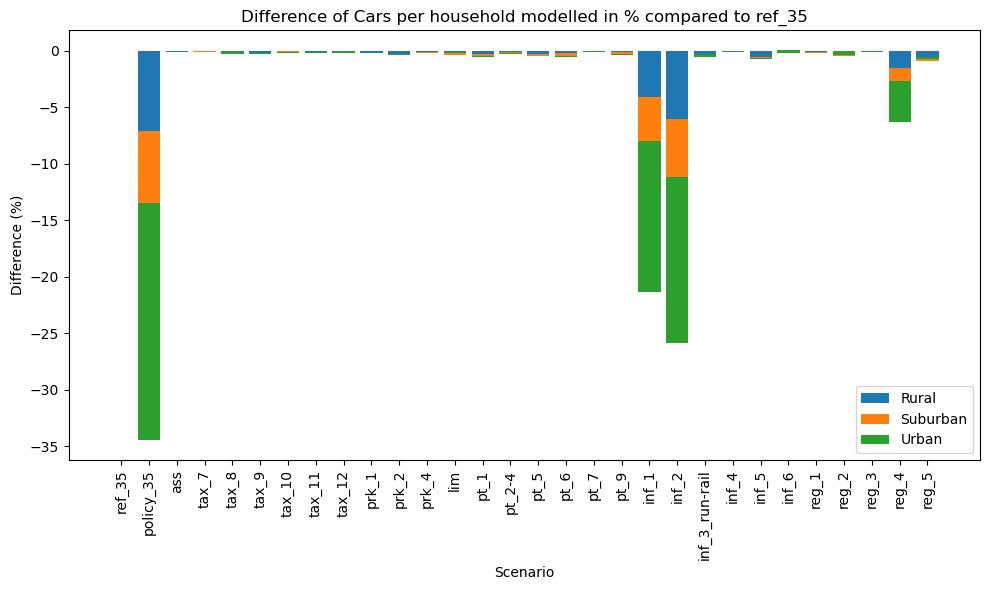

<Figure size 640x480 with 0 Axes>

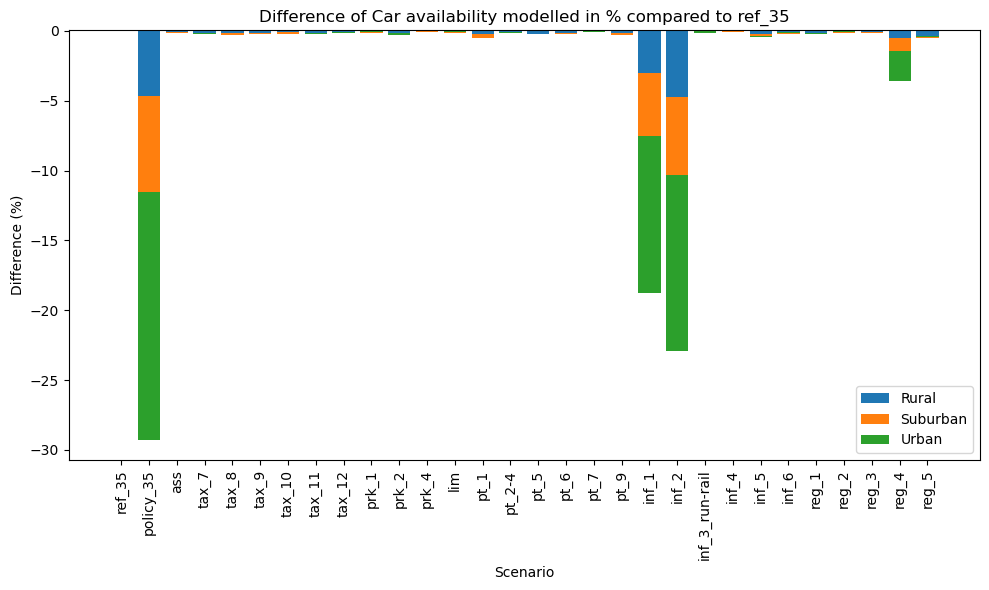

<Figure size 640x480 with 0 Axes>

In [36]:
# plot the data, for every urbanisation type with values for all scenarios in it
to_analyse = ["Cars per household modelled", "Car availability modelled"]
save_name = ["car_p_hh", "car_avail"]

for idx, var in enumerate(to_analyse):
    df = excl_merged.loc[excl_merged['key'] == var]
    df = swap_columns(df, "key", "scenario")
    df = df.drop(columns = ["choice", "key"]).reset_index(drop=True)
    
    # plot absolute data in separate bar charts
    for urb in ["rural", "suburban", "urban"]:
        cars = df[['scenario', urb]]
        # create bar chart
        fig = plt.figure(figsize=(10,5))
        plt.bar(cars['scenario'], cars[urb], width =0.7)
        plt.xticks(rotation=90)
        plt.xlabel('Scenario')
        plt.ylabel(f'{var} {urb}')
        plt.savefig(save_path + save_name[idx] + "_" + urb + ".pdf", bbox_inches='tight')
        plt.close(fig)
        
    # plot difference in percent compared to ref_35 in stacked bar plot
    ref_35_row = df[df['scenario'] == 'ref_35'].iloc[0]
    df['rural_diff'] = ((df['rural'] - ref_35_row['rural']) / ref_35_row['rural']) * 100
    df['suburban_diff'] = ((df['suburban'] - ref_35_row['suburban']) / ref_35_row['suburban']) * 100
    df['urban_diff'] = ((df['urban'] - ref_35_row['urban']) / ref_35_row['urban']) * 100

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    x = df['scenario'][1:]
    y_rural = df['rural_diff'][1:]
    y_suburban = df['suburban_diff'][1:]
    y_urban = df['urban_diff'][1:]

    ax.bar(x, y_rural, label='Rural')
    ax.bar(x, y_suburban, label='Suburban', bottom=y_rural)
    ax.bar(x, y_urban, label='Urban', bottom=y_rural + y_suburban)

    ax.set_ylabel('Difference (%)')
    ax.set_xlabel('Scenario')
    ax.set_title(f'Difference of {var} in % compared to ref_35')

    ax.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path + save_name[idx] + "_percent_change.pdf", bbox_inches='tight')

## Compare (local and long-distance) emissions for different scenarios

In [54]:
'''
# still in work for combination of long-distance and short-distance emissions
# define output excel file to be read for every scenario (every folder in 'output')
file_name = 'results_total.xlsx'
sheet_name__local = 'emissions_local'
sheet_name_long = 'emissions_long'
modes_local = ['bus', 'car', 'rail_short', 'walk']
modes_long = ['air', 'bus', 'coach', 'rail_long', 'rail_short', 'car_long']
unit = 'mio tCO2eq'

# create a list with all paths to the files to be compared
file_list = []
for x in range(len(scenarios)):
    file_list.append(os.path.join(output_path, scenarios[x], file_name))

# read the data for every scenario and combine it in one list
# local emissions as list
excl_list_local = []
for x in range(len(file_list)):
    excl_list_local.append(pd.read_excel(file_list[x], sheet_name=sheet_name__local))
    
# convert the list to a pandas DataFrame for better handling
excl_merged_local = pd.DataFrame()
for excl_file in excl_list_local:
    excl_merged_local = pd.concat([excl_merged_local, excl_file], ignore_index=True)

excl_merged_local.rename({'route_type':'mode'}, axis=1, inplace=True)
to_replace = {'bus': 'bus_local', 'rail_short': 'rail_local', 'car': 'car_local'}
excl_merged_local['mode'].replace(to_replace, inplace=True)
    
# long distance emissions as list
excl_list_long = []
for x in range(len(file_list)):
    excl_list_long.append(pd.read_excel(file_list[x], sheet_name=sheet_name_long))

# convert the list to a pandas DataFrame for better handling
excl_merged_long = pd.DataFrame()
for excl_file in excl_list_local:
    excl_merged_long = pd.concat([excl_merged_long, excl_file], ignore_index=True)

excl_merged_long.rename({'route_type':'mode'}, axis=1, inplace=True)
excl_merged_long['mode'].replace({'bus': 'bus_long'}, inplace=True)

#excl_merged['route_type'].fillna(excl_merged['Unnamed: 0'], inplace=True)
#excl_merged.rename({'route_type':'mode'}, axis=1, inplace=True)
#excl_merged.drop('Unnamed: 0', axis=1, inplace=True)

# Add sxenario names to pandas dataframes
# local emissions
excl_merged_local['scenario'] = ""
for x in range(len(scenarios)):
    # write the name in the scenario to all respective modes
    for y in range(0, len(modes_local)):
        excl_merged_local['scenario'][y+x*len(modes_local)] = scenarios[x]

# long distance emissions
excl_merged_long['scenario'] = ""
for x in range(len(scenarios)):
    # add a row for 'air' if that row is missing (= no air travel)
    for mode in modes_long:
        mode = f"{mode}"
        if excl_merged_long['mode'][x*len(modes_long)+modes_long.index(mode)] != mode:  
            excl_merged_long.loc[x*len(modes_long)+modes_long.index(mode)-0.5] = [mode, 0.0, np.nan]
            excl_merged_long = excl_merged_long.sort_index().reset_index(drop=True)
    # write the name in the scenario to all repective modes
    for y in range(len(modes_long)):
        excl_merged_long['scenario'][y+x*len(modes_long)] = scenarios[x]
print(excl_merged_long.tail(20))

excl_merged = pd.concat([excl_merged_local, excl_merged_long], ignore_index=True)
excl_merged = swap_columns(excl_merged, unit, 'scenario')
print(excl_merged.tail(20))
'''

/tmp/ipykernel_79600/3319434265.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged_local['scenario'][y+x*len(modes_local)] = scenarios[x]
/tmp/ipykernel_79600/3319434265.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged_long['scenario'][y+x*len(modes_long)] = scenarios[x]
/tmp/ipykernel_79600/3319434265.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged_long['scenario'][y+x*len(modes_long)] = 

           mode  mio tCO2eq scenario
290    bus_long    2.244588         
291         car   16.504830         
292  rail_short    0.416082         
293        walk    0.000000         
294    bus_long    2.240020         
295         car   16.458615         
296  rail_short    0.415373         
297        walk    0.000000         
298    bus_long    2.232117         
299         car   16.390889         
300  rail_short    0.413502         
301        walk    0.000000         
302    bus_long    1.840282         
303         car   14.821240         
304  rail_short    0.303495         
305        walk    0.000000         
306    bus_long    2.236459         
307         car   16.567880         
308  rail_short    0.414566         
309        walk    0.000000         
           mode scenario  mio tCO2eq
414    bus_long             2.244588
415         car            16.504830
416  rail_short             0.416082
417        walk             0.000000
418    bus_long             2.240020
4

/tmp/ipykernel_79600/3319434265.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged_long['scenario'][y+x*len(modes_long)] = scenarios[x]
/tmp/ipykernel_79600/3319434265.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged_long['scenario'][y+x*len(modes_long)] = scenarios[x]
/tmp/ipykernel_79600/3319434265.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excl_merged_long['scenario'][y+x*len(modes_long)] = sc

In [21]:
'''
# plot the data, for every mode type their own plot with values for all scenarios in it
# only for emissions_long (mode_2)
for mode in modes_2:
    emiss = excl_merged.drop(excl_merged[excl_merged['mode'] != mode].index)
    # create bar chart
    fig = plt.figure(figsize=(10,5))
    plt.bar(emiss['scenario'], emiss[unit], width =0.7)  # xdata, ydata
    plt.xticks(rotation=90)
    plt.xlabel('Scenario')
    plt.ylabel(f'{mode} {sheet_name} ({unit})')
    plt.savefig(output_path + '/scenario_comparison/' + mode + '_' + sheet_name + '.pdf', bbox_inches='tight')
    plt.close(fig)
    
'''

"\n# plot the data, for every mode type their own plot with values for all scenarios in it\n# only for emissions_long (mode_2)\nfor mode in modes_2:\n    emiss = excl_merged.drop(excl_merged[excl_merged['mode'] != mode].index)\n    # create bar chart\n    fig = plt.figure(figsize=(10,5))\n    plt.bar(emiss['scenario'], emiss[unit], width =0.7)  # xdata, ydata\n    plt.xticks(rotation=90)\n    plt.xlabel('Scenario')\n    plt.ylabel(f'{mode} {sheet_name} ({unit})')\n    plt.savefig(output_path + '/scenario_comparison/' + mode + '_' + sheet_name + '_all_scen.pdf', bbox_inches='tight')\n    plt.close(fig)\n    \n"

In [ ]:
'''
# old version
# still in work for combination of long-distance and short-distance emissions
# define output excel file to be read for every scenario (every folder in 'output')
file_name = 'results_total.xlsx'
sheet_name_1 = 'emissions_local'
sheet_name_2 = 'emissions_long'
modes_1 = ['bus', 'car', 'rail_short', 'walk']
modes_2 = ['air', 'bus', 'coach', 'rail_long', 'rail_short', 'car_long']
unit = 'mio tCO2eq'

# create a list with all paths to the files to be compared
file_list = []
for x in range(len(scenarios)):
    file_list.append(os.path.join(output_path, scenarios[x], file_name))

# read the data for every scenario and combine it in one list
excl_list = []
# local emissions
#for x in range(len(file_list)):
#    excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name_1))
# long distance emissions
for x in range(len(file_list)):
    excl_list.append(pd.read_excel(file_list[x], sheet_name=sheet_name_2))
    
# convert the list to a pandas DataFrame for better handling
excl_merged = pd.DataFrame()
for excl_file in excl_list:
    excl_merged = excl_merged.append(excl_file, ignore_index=True)
#excl_merged['route_type'].fillna(excl_merged['Unnamed: 0'], inplace=True)
#excl_merged.rename({'route_type':'mode'}, axis=1, inplace=True)
#excl_merged.drop('Unnamed: 0', axis=1, inplace=True)
excl_merged.rename({'Unnamed: 0':'mode'}, axis=1, inplace=True)

# add the scenario name to the data in the pandas DataFrame
excl_merged['scenario'] = ""
# local emissions
#for x in range(len(scenarios)):
#    for y in range(len(modes_1)):
#        excl_merged['scenario'][y+x*len(modes_1)] = scenarios[x]
# long distance emissions
for x in range(len(scenarios)):
    for y in range(len(modes_2)):
        excl_merged['scenario'][y+x*len(modes_2)] = scenarios[x] #+len(modes_1)*len(scenarios)

        
# define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df
excl_merged = swap_columns(excl_merged, unit, 'scenario')
print(excl_merged.head(20))
'''